In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation
import csv
import math


class Tycho2Reader:
    def __init__(self, filename):
        self.filename = filename

    def read_stars(self):
        stars = []
        skipped_rows = 0
        with open(self.filename, "r") as file:
            reader = csv.reader(file, delimiter="|")
            for i, row in enumerate(reader):
                try:
                    ra = float(row[24].strip())
                    dec = float(row[25].strip())

                    # Try to get VT magnitude, fallback to BT if VT is empty
                    vt_mag = row[20].strip()
                    if vt_mag:
                        mag = float(vt_mag)
                    else:
                        bt_mag = row[17].strip()
                        if bt_mag:
                            mag = float(bt_mag)
                        else:
                            # Skip this star if both VT and BT are missing
                            raise ValueError("Both VT and BT magnitudes are missing")

                    stars.append({"RAdeg": ra, "DEdeg": dec, "Mag": mag})

                    # Debug output for every 10000th star
                    if i % 10000 == 0:
                        print(f"Star {i}: RA={ra}, Dec={dec}, Mag={mag}")

                except (ValueError, IndexError) as e:
                    skipped_rows += 1
                    if skipped_rows <= 10:
                        print(f"Skipping row {i} due to error: {e}")
                        print(f"Problematic row: {row}")
                    elif skipped_rows == 11:
                        print("Further skipped rows will not be printed...")

        print(f"Total stars read: {len(stars)}")
        print(f"Total rows skipped: {skipped_rows}")
        return pd.DataFrame(stars)


def ra_dec_to_eci(ra, dec):
    ra_rad = np.radians(ra)
    dec_rad = np.radians(dec)
    x = np.cos(ra_rad) * np.cos(dec_rad)
    y = np.sin(ra_rad) * np.cos(dec_rad)
    z = np.sin(dec_rad)
    return np.array([x, y, z])


def eci_to_body_frame(eci_coords, attitude_matrix):
    return attitude_matrix @ eci_coords


def project_to_image_plane(body_coords, fov, resolution):
    f = 1 / np.tan(np.radians(fov) / 2)
    x, y, z = body_coords
    if z > 0:
        u = f * x / z
        v = f * y / z
        width, height = resolution
        pixel_x = int((u + 1) * width / 2)
        pixel_y = int((v + 1) * height / 2)
        if 0 <= pixel_x < width and 0 <= pixel_y < height:
            return pixel_x, pixel_y
    return None


# Load Tycho-2 data
reader = Tycho2Reader("data/tycho2/catalog.dat")
stars_df = reader.read_stars()

# Convert columns to numeric type and filter brighter stars
stars_df["RAdeg"] = pd.to_numeric(stars_df["RAdeg"], errors="coerce")
stars_df["DEdeg"] = pd.to_numeric(stars_df["DEdeg"], errors="coerce")
stars_df["Mag"] = pd.to_numeric(stars_df["Mag"], errors="coerce")

# Filter brighter stars
bright_stars = stars_df[stars_df["Mag"] <= 9].dropna(subset=["RAdeg", "DEdeg", "Mag"])

print(f"Number of bright stars: {len(bright_stars)}")
print(
    f"RA range: {bright_stars['RAdeg'].min():.2f} to {bright_stars['RAdeg'].max():.2f}"
)
print(
    f"Dec range: {bright_stars['DEdeg'].min():.2f} to {bright_stars['DEdeg'].max():.2f}"
)

Star 0: RA=2.31754222, Dec=2.23186444, Mag=0.223
Star 10000: RA=50.51682583, Dec=4.25786417, Mag=0.128
Star 20000: RA=78.94305694, Dec=6.572215, Mag=0.178
Star 30000: RA=104.55569361, Dec=1.31477861, Mag=0.263
Star 40000: RA=111.99879056, Dec=2.08969778, Mag=0.025
Star 50000: RA=120.60343972, Dec=3.09444972, Mag=0.161
Star 60000: RA=156.22217472, Dec=2.61771333, Mag=0.428
Star 70000: RA=213.23062694, Dec=0.69112444, Mag=0.052
Star 80000: RA=253.77198278, Dec=4.26539944, Mag=0.121
Star 90000: RA=277.13315361, Dec=4.37883861, Mag=0.051
Star 100000: RA=293.82417694, Dec=1.28518167, Mag=0.076
Star 110000: RA=303.886015, Dec=6.86840306, Mag=0.077
Star 120000: RA=334.39570083, Dec=1.93288278, Mag=0.211
Star 130000: RA=20.37176778, Dec=12.31844583, Mag=0.289
Star 140000: RA=68.9804975, Dec=11.12646111, Mag=0.224
Star 150000: RA=91.95597972, Dec=9.03280944, Mag=0.142
Star 160000: RA=105.59932167, Dec=9.67266444, Mag=0.174
Star 170000: RA=114.77668889, Dec=14.97678611, Mag=0.117
Star 180000: RA

In [26]:
def calculate_star_visibility(magnitude, iso, aperture, exposure_time, sky_brightness):
    """
    Calculate the visibility of a star based on camera settings and observing conditions.

    :param magnitude: Apparent magnitude of the star
    :param iso: Camera ISO setting
    :param aperture: Lens aperture (f-number)
    :param exposure_time: Exposure time in seconds
    :param sky_brightness: Sky brightness in magnitudes per square arcsecond
    :return: Visibility score (higher is more visible)
    """
    # Convert magnitude to relative brightness
    star_brightness = 10 ** (-0.4 * magnitude)

    # Calculate the light gathering power of the lens
    light_gathering = (1 / aperture) ** 2

    # Calculate the camera's sensitivity
    camera_sensitivity = iso / 100

    # Calculate the total light collected
    signal = star_brightness * light_gathering * exposure_time * camera_sensitivity

    # Calculate the sky background noise
    sky_brightness_linear = 10 ** (-0.4 * sky_brightness)
    noise = math.sqrt(
        sky_brightness_linear * light_gathering * exposure_time * camera_sensitivity
    )

    # Calculate the signal-to-noise ratio
    snr = signal / noise

    return snr


def add_star_to_image(image, x, y, visibility):
    height, width = image.shape
    y_min, y_max = max(0, y - 2), min(height, y + 3)
    x_min, x_max = max(0, x - 2), min(width, x + 3)

    y_range = np.arange(y_min, y_max)
    x_range = np.arange(x_min, x_max)

    y_grid, x_grid = np.meshgrid(y_range - y, x_range - x, indexing="ij")

    r_squared = x_grid**2 + y_grid**2
    gaussian = np.exp(-r_squared / (2 * 0.5**2))

    image[y_min:y_max, x_min:x_max] += visibility * gaussian


def generate_star_image(stars_df, attitude_matrix, fov, resolution, iso, shutter_speed):
    width, height = resolution
    image = np.zeros((height, width))
    visible_stars = 0
    total_stars = len(stars_df)
    stars_in_fov = 0

    for _, star in stars_df.iterrows():
        ra, dec, magnitude = star["RAdeg"], star["DEdeg"], star["Mag"]
        if np.isnan(ra) or np.isnan(dec) or np.isnan(magnitude):
            print("Skipping star with missing data")
            continue  # Skip stars with missing data

        eci_coords = ra_dec_to_eci(ra, dec)
        body_coords = eci_to_body_frame(eci_coords, attitude_matrix)

        # Check if star is in front of the camera
        if body_coords[2] > 0:
            stars_in_fov += 1

        projection = project_to_image_plane(body_coords, fov, resolution)

        if projection:
            x, y = projection
            # visibility = calculate_star_visibility(magnitude, iso, shutter_speed)
            aperture = 1.4
            exposure_time = shutter_speed
            sky_brightness = 21
            visibility = calculate_star_visibility(magnitude, iso, aperture, exposure_time, sky_brightness)
            add_star_to_image(image, x, y, visibility)
            visible_stars += 1
            if visible_stars <= 10:  # Print details for first 10 visible stars
                print(
                    f"Star: RA={ra:.2f}, Dec={dec:.2f}, Mag={magnitude:.2f}, Pixel=({x},{y})"
                )

    print(f"Total stars: {total_stars}")
    print(f"Stars in front of camera: {stars_in_fov}")
    print(f"Visible stars: {visible_stars}")
    return image

Star: RA=163.21, Dec=29.84, Mag=0.20, Pixel=(25,598)
Star: RA=167.40, Dec=29.73, Mag=0.03, Pixel=(9,523)
Star: RA=167.39, Dec=29.64, Mag=0.06, Pixel=(6,523)
Star: RA=164.28, Dec=29.74, Mag=0.24, Pixel=(19,579)
Star: RA=165.46, Dec=29.87, Mag=0.01, Pixel=(19,557)
Star: RA=165.46, Dec=29.87, Mag=0.02, Pixel=(19,557)
Star: RA=166.02, Dec=29.95, Mag=0.17, Pixel=(19,547)
Star: RA=164.53, Dec=29.23, Mag=0.07, Pixel=(3,577)
Star: RA=165.87, Dec=29.47, Mag=0.23, Pixel=(6,551)
Star: RA=165.80, Dec=29.30, Mag=0.10, Pixel=(1,553)
Total stars: 2539893
Stars in front of camera: 1201282
Visible stars: 21840


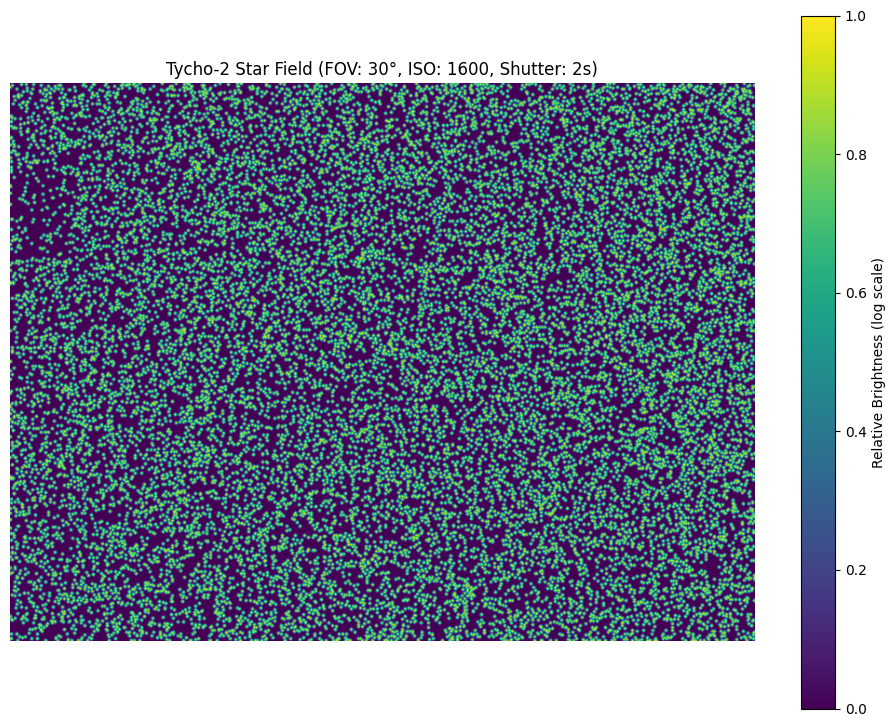

Image shape: (600, 800)
Min pixel value: 0.0
Max pixel value: 1.0
Mean pixel value: 0.2814692391125905


In [27]:
# Set parameters
fov = 30  # Field of view in degrees
resolution = (800, 600)
iso = 1600
shutter_speed = 2

# Set camera attitude (pointing towards a region with more vertical spread)
ra_center = 0  # Right ascension of vernal equinox
dec_center = 45  # Midway between celestial equator and north celestial pole
rot = Rotation.from_euler("zyx", [-ra_center, 90 - dec_center, 0], degrees=True)
attitude_matrix = rot.as_matrix()

# Generate image
image = generate_star_image(
    bright_stars, attitude_matrix, fov, resolution, iso, shutter_speed
)

# Apply logarithmic scaling and normalization
image = np.log1p(image)
image /= np.max(image) if np.max(image) > 0 else 1

# Display the image
plt.figure(figsize=(12, 9))
plt.imshow(image, cmap="viridis", origin="lower")
plt.title(f"Tycho-2 Star Field (FOV: {fov}°, ISO: {iso}, Shutter: {shutter_speed}s)")
plt.axis("off")
plt.colorbar(label="Relative Brightness (log scale)")
plt.show()

# Print some statistics about the image
print(f"Image shape: {image.shape}")
print(f"Min pixel value: {image.min()}")
print(f"Max pixel value: {image.max()}")
print(f"Mean pixel value: {image.mean()}")